# Imports and Data

In [1]:
from typing import NamedTuple
import pandas as pd
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import lru_cache


class CollegeMessage(NamedTuple):
    source: int  #source id
    target: int  # target id
    unix_timestamp: int  # seconds after last epoc


def read_message_data(datapath: str) -> list[CollegeMessage]:
    filepath = Path.cwd() / Path(datapath)

    if not filepath.exists():
        raise FileNotFoundError(
            f"File not found: {filepath}; " +
            f"Current working directory: {Path.cwd()}; " +
            f"Relative path to data file: {Path(datapath)}"
        )

    print(f"Using file: {filepath.absolute()}")

    messages = []
    with open(filepath, 'r', encoding="UTF-8") as f:
        for line in f:
            source, target, timestamp = line.strip().split()
            messages.append(CollegeMessage(int(source), int(target), int(timestamp)))
    print("done")
    return messages


def remove_low_degree_nodes(data: pd.DataFrame, min_degree: int) -> pd.DataFrame:
    in_degree = data['target'].value_counts()
    out_degree = data['source'].value_counts()
    high_degree_nodes = set(in_degree[in_degree >= min_degree].index) & set(out_degree[out_degree >= min_degree].index)
    return data[data['source'].isin(high_degree_nodes) & data['target'].isin(high_degree_nodes)]


def create_graph(data: pd.DataFrame) -> nx.DiGraph:
    digraph = nx.DiGraph()

    for row in data.itertuples(index=False):
        digraph.add_edge(row.source, row.target, timestamp=row.unix_timestamp)

    return digraph


def graph_figure(graph: nx.DiGraph):
    pos = nx.arf_layout(graph)
    nx.draw(graph, pos, with_labels=False, node_size=10)


# Layout calculations, cached by LRU to avoid recalculating the layout
@lru_cache(maxsize=None)
def cache_layout(graph: nx.DiGraph, layout_func: callable):
    print("Calculating layout ...")
    layout = layout_func(graph)
    print("... done calculating layout")
    return layout

In [2]:
_DATA_PATH = "./dataset/CollegeMsg.txt"

_MESSAGES = read_message_data(_DATA_PATH)

DF_MESSAGES = remove_low_degree_nodes(pd.DataFrame(_MESSAGES), 2)

GRAPH_MESSAGES = create_graph(DF_MESSAGES)

Using file: C:\Users\majerm\projects\local\rug-sna-pizza-giving\college_msg_files\dataset\CollegeMsg.txt
done


In [3]:
DF_MESSAGES.head()

,source,target,unix_timestamp
39,41,42,1082574211
48,36,50,1082597715
49,44,51,1082597751
50,32,52,1082598056
51,36,32,1082598122


# Time window

In [30]:
def time_window(graph: nx.DiGraph, unix_start: int, unix_end: int) -> nx.DiGraph:
    return graph.edge_subgraph([
        (source, target)
        for source, target, timestamp in graph.edges(data='timestamp')
        if unix_start <= timestamp <= unix_end
    ]).copy()  # Ensure subgraph is a copy


import networkx as nx
from pathlib import Path
from matplotlib.colors import Normalize
from datetime import datetime
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

def export_graph_undirected(
        graph: nx.Graph,
        pos: dict,
        title: str,
        export_path: Path = None,
        fig_size=(20, 20),
        base_node_size=1,
        node_size_factor=10,
        edge_alpha=0.2,
        edge_color='gray',
        default_node_color='lightgray',
        num_communities=6,
        dpi=300,
        xlim=None,
        ylim=None
):
    # Create a new figure with the specified size
    plt.figure(figsize=fig_size)

    # Calculate degrees
    degrees = dict(graph.degree())

    # Detect communities using the Louvain method
    partition = nx.community.louvain_communities(graph)
    
    sorted_communities = sorted(partition, key=len, reverse=True)[:num_communities]
    
    # Prepare color mapping based on the top communities
    community_mapping = {}
    for idx, community in enumerate(sorted_communities):
        for node in community:
            community_mapping[node] = idx
    
    # Filter nodes to include only those in the top communities
    filtered_nodes = [node for node in graph.nodes() if node in community_mapping]
    
    # Filter edges to include only those between filtered nodes
    filtered_edges = [(u, v) for u, v in graph.edges() if u in filtered_nodes and v in filtered_nodes]
    
    # Create a subgraph with only filtered nodes and edges
    filtered_graph = graph.subgraph(filtered_nodes).edge_subgraph(filtered_edges).copy()

    # Scale node sizes
    node_sizes = [base_node_size + degrees[node] * node_size_factor for node in filtered_nodes]

    # Nodes not in the top communities will not be rendered
    cmap = plt.get_cmap('tab10', len(sorted_communities))
    node_colors = [
        cmap(community_mapping[node]) for node in filtered_nodes
    ]

    # Prepare edge widths
    edge_weights = [filtered_graph[u][v]['weight'] if 'weight' in filtered_graph[u][v] else 1 for u, v in filtered_graph.edges()]
    if edge_weights:
        max_weight = max(edge_weights)
        min_weight = min(edge_weights)
        min_width = 0.5
        max_width = 2
        if max_weight == min_weight:
            edge_widths = [(max_width + min_width) / 2 for _ in edge_weights]
        else:
            edge_widths = [
                min_width + (weight - min_weight) / (max_weight - min_weight) * (max_width - min_width)
                for weight in edge_weights
            ]
    else:
        edge_widths = []

    # Draw edges
    nx.draw_networkx_edges(
        filtered_graph,
        pos,
        alpha=edge_alpha,
        edge_color=edge_color,
        width=edge_widths
    )

    # Draw nodes
    nx.draw_networkx_nodes(
        filtered_graph,
        pos,
        nodelist=filtered_nodes,
        node_size=node_sizes,
        node_color=node_colors,
        linewidths=0.5
    )

    top_3_nodes = sorted(degrees, key=degrees.get, reverse=True)[:3]
    nx.draw_networkx_labels(filtered_graph, pos, labels={n: n for n in top_3_nodes if n in filtered_nodes}, font_size=14, font_color="black")

    # Add graph label with number of nodes and edges
    plt.title(f"Top {num_communities} Communities - Highlighting Community {num_communities}")

    # Set consistent axis limits
    if xlim and ylim:
        plt.xlim(xlim)
        plt.ylim(ylim)

    # Add a legend to make the top communities clearer
    community_patches = [
        mpatches.Patch(color=cmap(i), label=f'Community {i} [size = {len(sorted_communities[i])}]')
        for i in range(len(sorted_communities))
    ]
    plt.legend(handles=community_patches, loc='best')

    # Optional: Remove axes for a cleaner look
    plt.axis('off')

    # Save the figure if an export path is provided
    if export_path:
        # Ensure the parent directory exists
        export_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(export_path, bbox_inches='tight', dpi=dpi, pad_inches=0.1)

    # Close the figure to free up memory
    plt.close()


def time_window_undirected(graph: nx.DiGraph, unix_start: int, unix_end: int) -> nx.Graph:
    """
    Extracts a subgraph within the specified time window, treating edges as undirected
    and aggregating the number of messages between node pairs.

    Parameters:
    - graph (nx.DiGraph): The original directed graph with 'timestamp' on edges.
    - unix_start (int): Start of the time window (inclusive).
    - unix_end (int): End of the time window (inclusive).

    Returns:
    - nx.Graph: An undirected graph with 'weight' attributes on edges.
    """
    # Filter edges within the time window
    filtered_edges = [
        (min(source, target), max(source, target))
        for source, target, timestamp in graph.edges(data='timestamp')
        if unix_start <= timestamp <= unix_end
    ]

    # Aggregate message counts between node pairs
    edge_weights = {}
    for src, dest in filtered_edges:
        if (src, dest) in edge_weights:
            edge_weights[(src, dest)] += 1
        else:
            edge_weights[(src, dest)] = 1

    # Create an undirected graph
    undirected_graph = nx.Graph()
    undirected_graph.add_nodes_from(graph.nodes(data=True))

    # Add edges with 'weight' attribute
    for (src, dest), weight in edge_weights.items():
        undirected_graph.add_edge(src, dest, weight=weight)

    return undirected_graph


Calculating layout ...
... done calculating layout


Exporting graphs:   5%|▍         | 1/21 [00:07<02:27,  7.35s/it]

KeyboardInterrupt



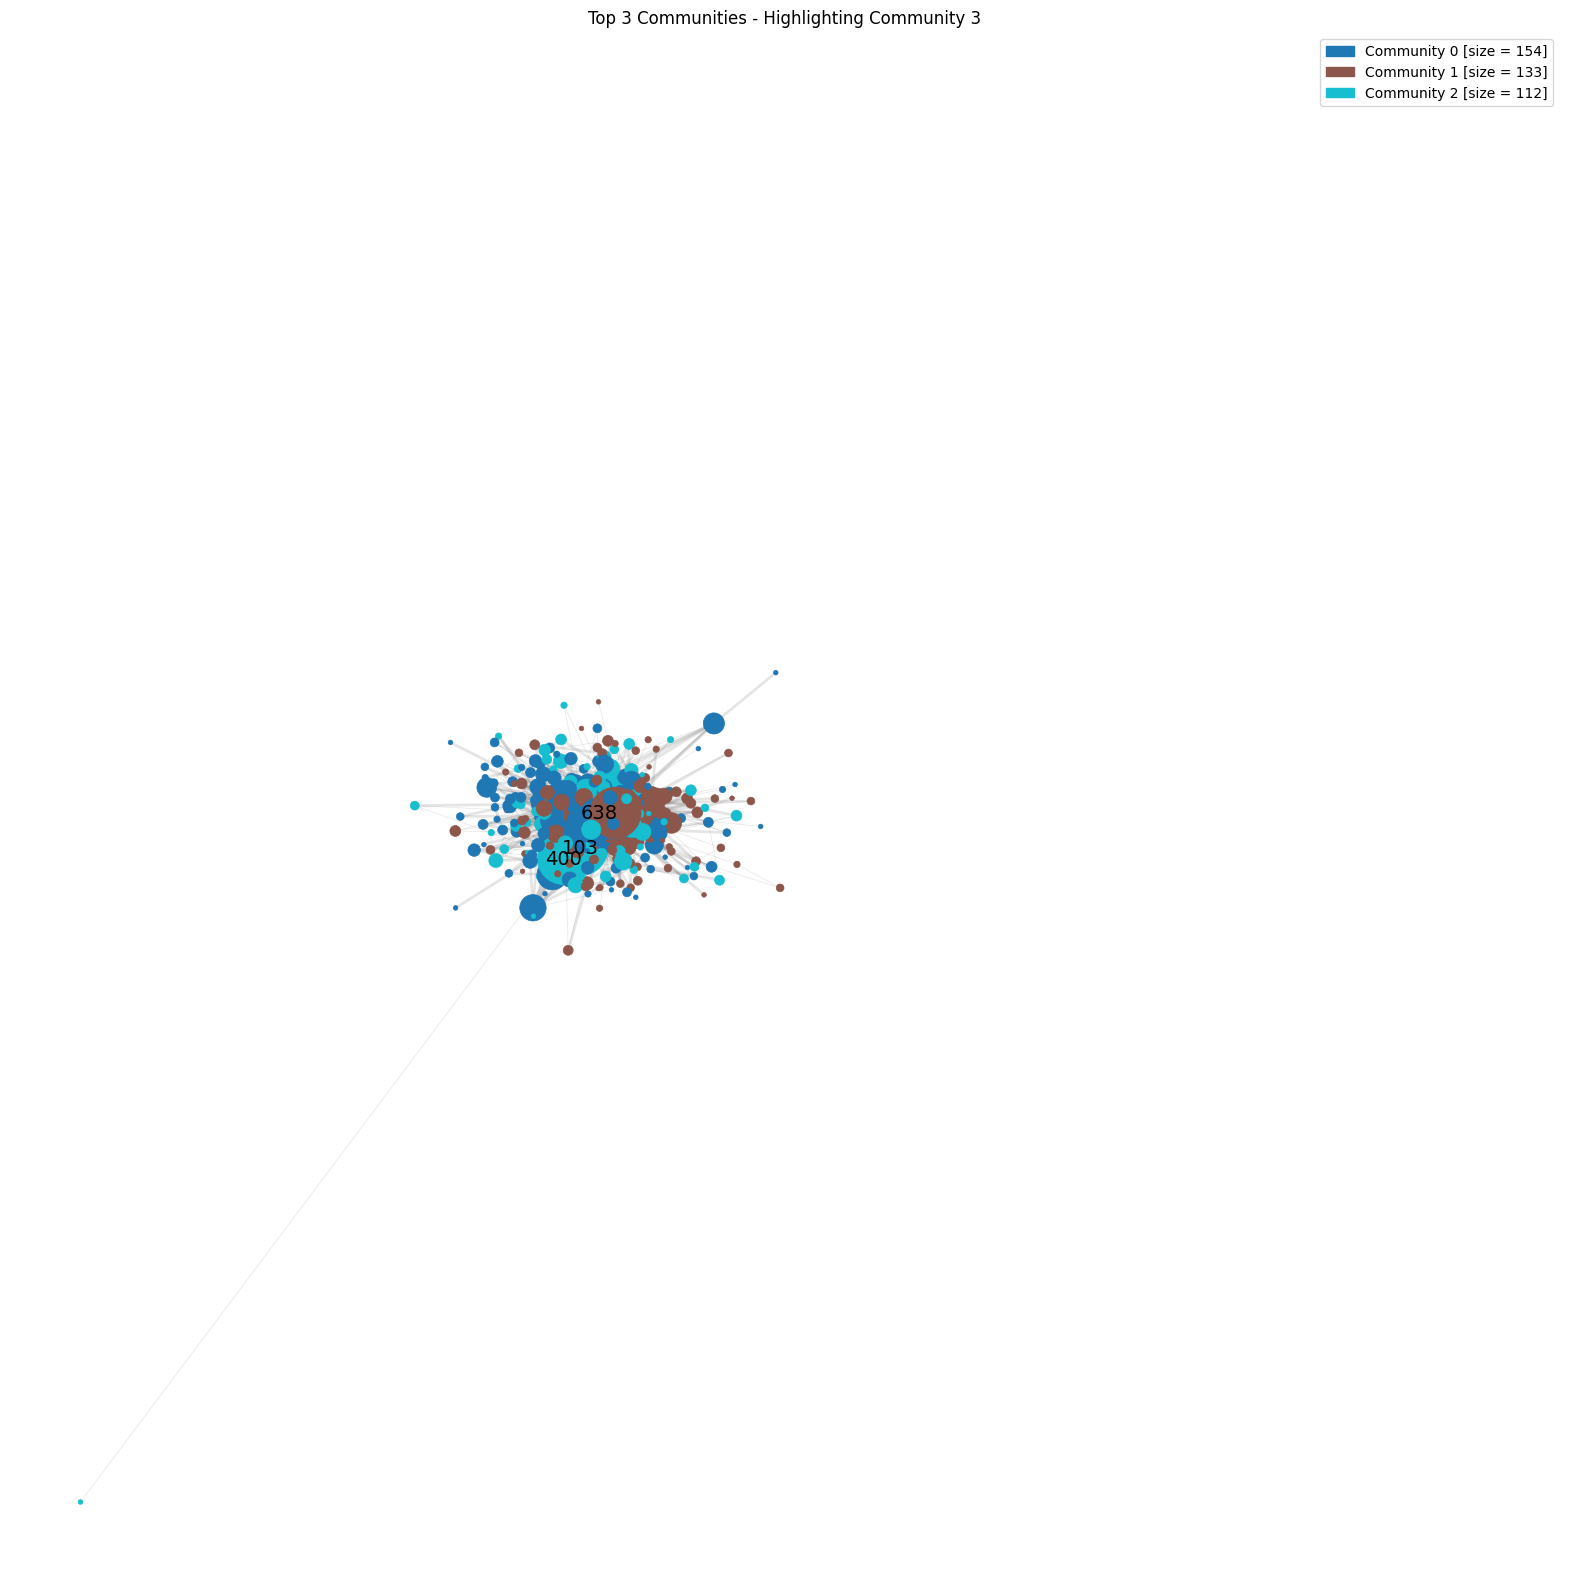

In [33]:
# variations = (
#     (7 * step, step) 
#     for step in range(1, 8)
# )


variations = [(28, 8)]

for variation in variations:
    export_time_windows_undirected(cache_layout(GRAPH_MESSAGES, nx.arf_layout), *variation, num_communities=3)
